# TSDF
## 一、介绍
三维重建最主要的部分曲面重建，物体由曲面构成，曲面是嵌入在$\mathscr{R}^3$空间中的二维流形。

曲面在数学上两种主要的表示方式，一种是参数化表示，对应曲面称为参数曲面(parametric surface)，其形式通常是$f:\mathscr{R}^2\rightarrow \mathscr{R}^3$，这是微分几何中常用到的曲面表达形式。第二种是隐式表达，对应曲面称为隐式曲面(implicit surface)，隐式曲面是通过隐式函数(implicit function)定义的曲面，隐式函数的形式通常是$f:\mathscr{R}^3\rightarrow \mathscr{R}$，而隐式曲面就是隐式函数的水平集$\{(x, y, z):f(x, y, z) = C\}$。
TSDF就是一种利用深度图构造曲面隐式函数的算法。

截断符号距离函数(truncated signed distance function,TSDF)在非常多实时的三维重建算法中都有应用，比如大名鼎鼎的KinectFusion。它给予三维场景**体素**(Voxel)表示，从而可以
**集成从不同视角拍摄的深度图**(range image)。TSDF处理速度快，可以并行计算。

## 二、原理
### 2.1 符号距离函数(SDF)

符号距离函数(signed distance function, SDF)最早提出用来从多张深度图像重建三维模型。

对观察者(相机)来说，一个曲面有外部和内部之分。我们把靠近观察者的部分称为曲面的外侧，反之称为内侧。

将曲面嵌入的高维空间($\mathscr{R}^3$)离散成体素(voxel)，体素的位置为中心坐标。每个体素$x$有两个特征，一个是符号距离函数(SDF)，记为$sdf_i(x)$。SDF的定义是体素距离目前曲面
最近的符号距离，其中在曲面外定义为正，在曲面内定义为负。另一个特征是权重$w_i(x)$，是对目前$sdf_i(x)$不确定性的评估，下标$i$代表第$i$次观测。

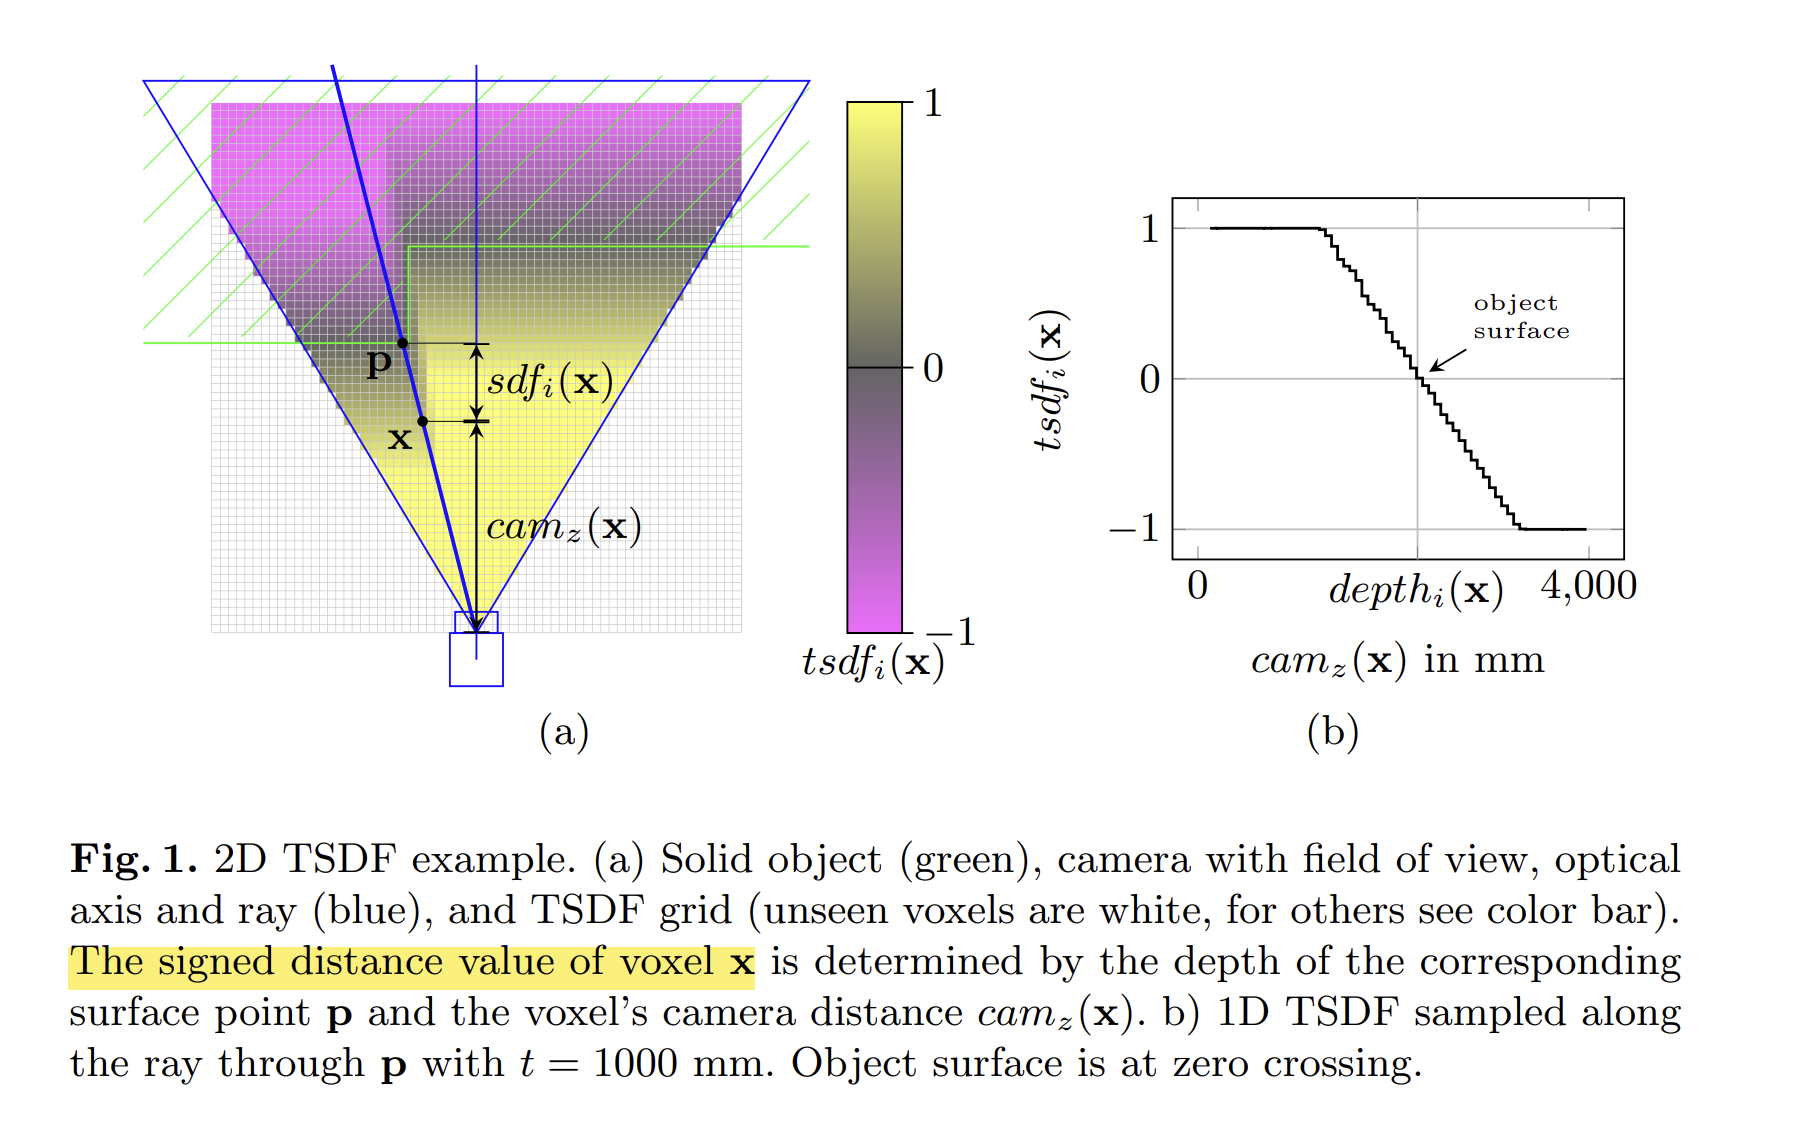

In [1]:
from PIL import Image
display(Image.open("../../resources/TSDF/SDF.png"))

In [ ]:
如上图所示，点x点处的SDF为：

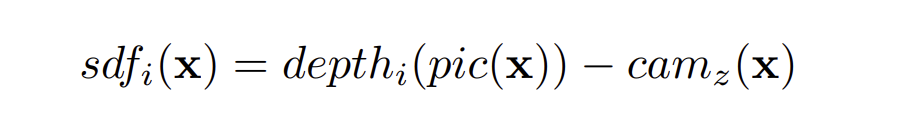

In [2]:
from PIL import Image
display(Image.open("../../resources/TSDF/SDF_cal.jpg"))

其中depth(pic(x))是将x投影到深度图上对应的点，即沿着光线最近物体表面点p到相机的深度。cam(x)是体素x到相机沿着光轴的距离，因此符号距离函数是**沿着相机光轴的距离**。

### 2.2 截断符号距离函数(TSDF)

截断符号距离函数(TSDF)就是在SDF的基础上，设置了截断阈值t

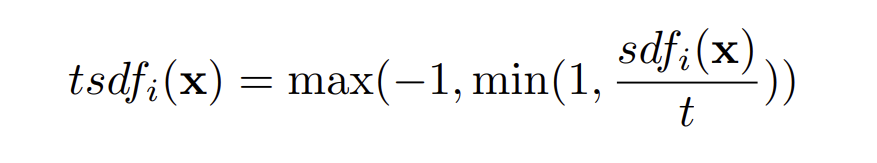

In [3]:
from PIL import Image
display(Image.open("../../resources/TSDF/TSDF.png"))

在$|sdf(x)|>t$的情况下，$tsdf(x)=1$。之所以这样设置是因为距离表面更远的体素对表面重建是没有帮助的。1.1中每个体素有$sdf$和权重两个值，这里改成$tsdf$和权重，更新算法都是一样的。
TSDF利用两个值不断更新来整合从不同视角传来的信息。更新公式为

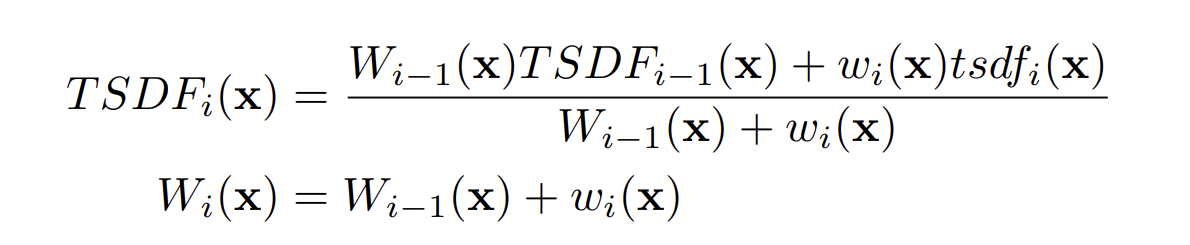

In [5]:
from PIL import Image
display(Image.open("../../resources/TSDF/TSDF_update.png"))

初始权重$W_0(x)=0$，网格$TSDF_0(x)=0$，每次观测对**相机视场中的体素**置权重$w_i(x)=1$，视场之外设置权重为$0$。除这种置权重$0,1$的方法外，
还可以将硬件测量误差考虑在内，比如Kinect越远估计越不准，则给更远的点更低的更新权重。

经过优化，物体表面就是定义在体素上TSDF函数的**零水平集**(zero-level-set)，若没有值为$0$的体素，则用线性插值解决。

### 2.3 移动立方体算法(MC)
TSDF算法可以求得一个定义在体素上的隐式函数(implicit function)$f(x, y, z)$，然而要求曲面的位置，还需要找出方程$f(x, y, z)=0$的解，移动立方体算法(Marching cube，MC)就是解决这一问题的算法。
MC算法的步骤为：
1. 先找到所有与隐函数等值面相交的体素，具体方法为计算每个体素8个顶点的隐式函数值，如果顶点的值有正有负则说明零等值面经过该体素。


2. 再分别找出每个体素与等值面相交的交面，具体就是要判断零等值面与体素12条边的哪些边相交，再通过相交边的两个顶点坐标进行线性插值获得交面交点对应的具体位置。
在MC算法中，将256种顶点状态根据对称性削减为以下14种，并表示成表，体素状态直接通过查表得到。

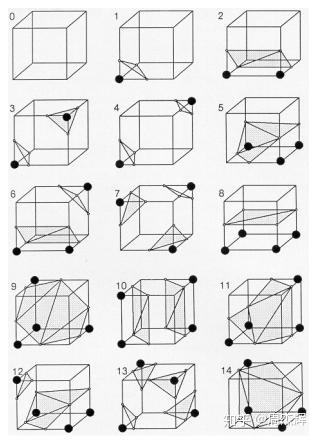

In [6]:
from PIL import Image
display(Image.open("../../resources/TSDF/MC.jpg"))

3. 这些交面连在一起就是等值面(重建曲面)，具体就是根据2中得到的三角面片顶点坐标，求得三角面片法向量。最后根据顶点坐标和顶点法向量进行三角面的连接。

注意：Marching Cube不是只能处理定义在规则体素上的隐式函数，还可以处理定义在八叉树(Octree)上的隐式函数。


### 2.4 体素哈希(Voxel hashing)
TSDF + Marching cubes算法组合非常适合GPU并行实现，在小规模场景下可以达到实时重建的效果。然而当重建更大规模场景时，体素的数目将远超GPU中可申请的最大线程数量，也就无法进行实时重建，而体素哈希技术(Voxel hashing)可以解决这个问题。

通过前面截断距离的设置得到截断距离函数(TSDF)，重建曲面并不需要$\mathscr{R}^3$中稠密的体素，只需要曲面附近截断距离内的小部分体素即可，因此关键的问题是如何设计一个可以利用TSDF表示下潜在**稀疏性**的数据结构[4]。

Voxel hashing算法认为世界被均匀的网格分为体素(Voxel)，每个体素包含一个TSDF值、颜色和权值。$8^3$个体素组成一个体素块(voxel block)。哈希表(hash table)数据结构由n个哈希条目(可以理解成数组下标)组成，哈希表对应哈希条目(hash entries)记录着体素块(Voxel Block)指针和对应的空间位置$\{x,y, z\}$。接着定义哈希函数（hash function）实现从空间位置 (x,y,z)到哈希条目（hash entries）的映射。这样可以直接通过空间坐标通过O(1)的时间复杂度检索到体素块。



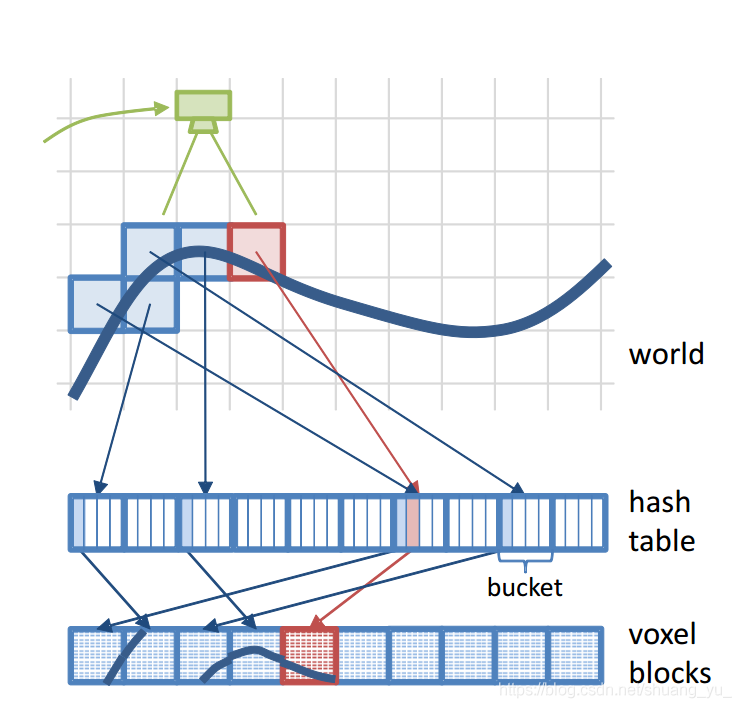

In [3]:
from PIL import Image
display(Image.open("../../resources/TSDF/voxel_hash.png"))

#### 处理冲突——哈希桶
因无法保证不同位置映射不同的哈希值，所以将每个哈希条目拓展为一个哈希桶(hash bucket)，哈希桶中包含多个哈希条目，对应同一个哈希值。当冲突发生时（即此时哈希桶中第一个哈希条目已经被占用），我们将体素块指针存储在哈希桶中的下一个可用的哈希条目中。


## 二、参考文献

[1] Werner D , Al-Hamadi A , Werner P . Truncated Signed Distance Function: Experiments on Voxel Size[C]// International Conference Image Analysis and Recognition. Springer, Cham, 2014.

[2] [PCL-TSDF](https://pcl.readthedocs.io/projects/tutorials/en/latest/using_kinfu_large_scale.html)

[3] [知乎-Marching Cube](https://zhuanlan.zhihu.com/p/48022195)